# The Auto Encoder
<!-- TODO: Give some info about what an autoencoder is and why its usefull -->
<!-- TODO: add and explain code for how to create and autoencoder, also describe how we used lightning to speed up on SLURM -->
I then trained the autoencoder on the dataset CIFAR100 for varying values of the number of latent dimensions on BluePebble. Let's now investigate our resulting models. First for an autoencoder with 128 latent dimensions. Let's first explore what the dataset looks like, we will now run some code chunks which will print out a grid of 4 of the images in CIFAR100 (training set) along with their labels:

In [1]:
# Do some imports from libraries and custom python scripts
import data
import matplotlib.pyplot as plt 
import torch.cuda as cuda 
import numpy as np
import torch
import torchvision

# We check the device
device = "cuda" if cuda.is_available() else "cpu"
print("Using device: ", device)

# Create the training and testing dataloaders and extract some images and their labels from the training set and test set
training_loader, test_loader = data.get_data_loader("CIFAR100", 64, device)
train_images, train_targets = next(iter(training_loader))
test_images, test_targets = next(iter(test_loader))

Using device:  cpu


100%|██████████| 169001437/169001437 [00:14<00:00, 12043955.56it/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [2]:
# We will now create a function which given the targets will return the corresponding labels
def cifar10_label(target):
    """
    Returns the label for a given target value in the CIFAR10 dataset.
    """
    cifar10_labels = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]
    return [cifar10_labels[t] for t in target]

def cifar100_label(target):
    """
    Returns the label for a given target value in the CIFAR100 dataset.
    """
    cifar100_labels = [
        'apple', 'aquarium_fish', 'baby', 'bear', 'beaver',
        'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl',
        'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can',
        'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee',
        'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile',
        'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish',
        'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo',
        'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
        'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle',
        'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange',
        'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck',
        'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
        'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
        'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper',
        'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower',
        'sweet_pepper', 'table', 'tank', 'telephone', 'television',
        'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle',
        'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
        'worm'
    ]
    return [cifar100_labels[t] for t in target]


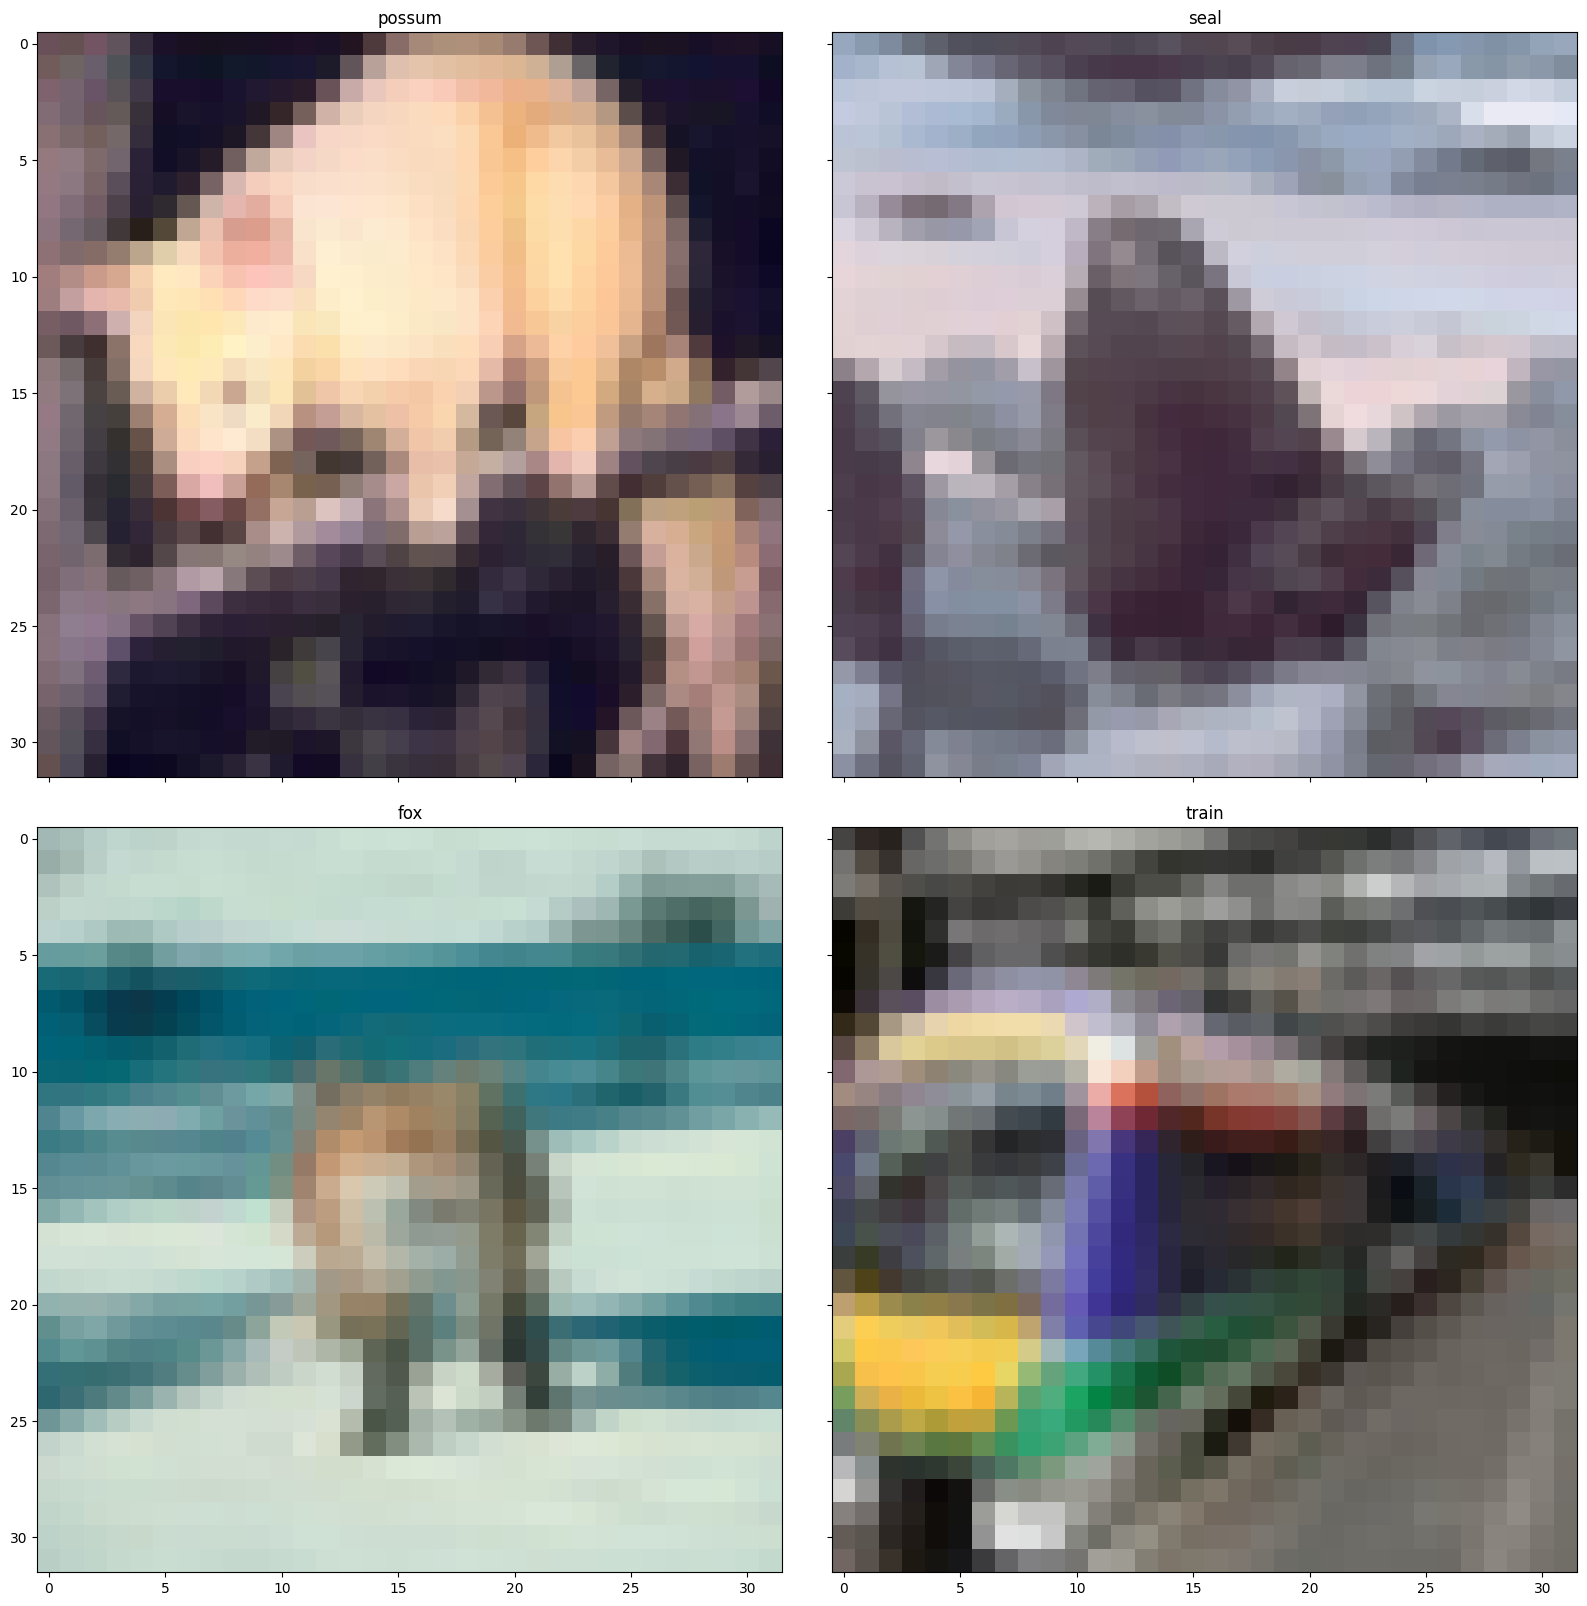

In [3]:
# Let's now print the image grid
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes
                 )
labels = cifar100_label(train_targets[:4])
for i, (ax, im) in enumerate(zip(grid, train_images[:4])):
    ax.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    ax.set_title('{0}'.format(labels[i]))

plt.show()

Above we can see some of the images from CIFAR100 with their class label written above. First we will look at how the autoencoder performs after being trained on the CIFAR100 training set with a latent dimension size of 128, as we mentioned earlier we trained the autoencoder on the HPC and made use of parallelization built into the lightning package to speed up the training process. Let's first look at what the training process looked like by plotting the mean reconstruction loss on the testing and training sets for each epoch.

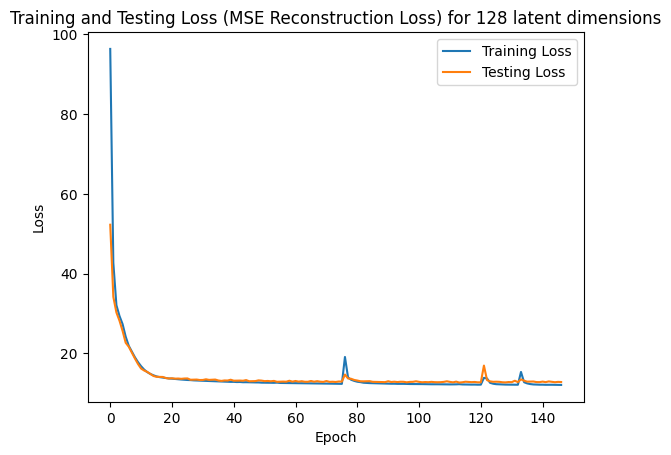

In [4]:
# Create plot of the training and testing loss from csv file
import pandas as pd
import matplotlib.pyplot as plt

# Create plot of the training and testing accuracy from csv file
def plot_loss(l_dim):
    # Read the csv file
    df_train = pd.read_csv("results/ae_" + str(l_dim) +"_train.csv")
    df_test = pd.read_csv("results/ae_" + str(l_dim) + "_test.csv")

    # Create the plot
    plt.plot(df_train["Value"], label="Training Loss")
    plt.plot(df_test["Value"], label="Testing Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Testing Loss (MSE Reconstruction Loss) for " + str(l_dim) + " latent dimensions")
    plt.legend()
    plt.show()

# Use the function we just created to plot the loss
plot_loss(128)

<!-- TODO: comment on training and testing above -->
Let's now run some images through the encoder part of the autoencoder and then through the decoder:

In [5]:
import VAE
# Load in our model that we trained on BluePebble
model = VAE.AutoEncoder.load_from_checkpoint("saved_models/autoencoder_128.ckpt")

# disable randomness, dropout, etc...
model.eval()

# Let's encode two of the images
encoded_images = model.encoder(train_images[:2])

# Let's now decode two of the images
decoded_images = model.decoder(encoded_images)



/home/jd18380/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-26 14:43:07.423846: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-26 14:43:07.447398: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 14:43:07.998538: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Lightni

We've now encoded and decoded two of our images, let's plot our decoded images from the autoencoder against the original images input to the network:

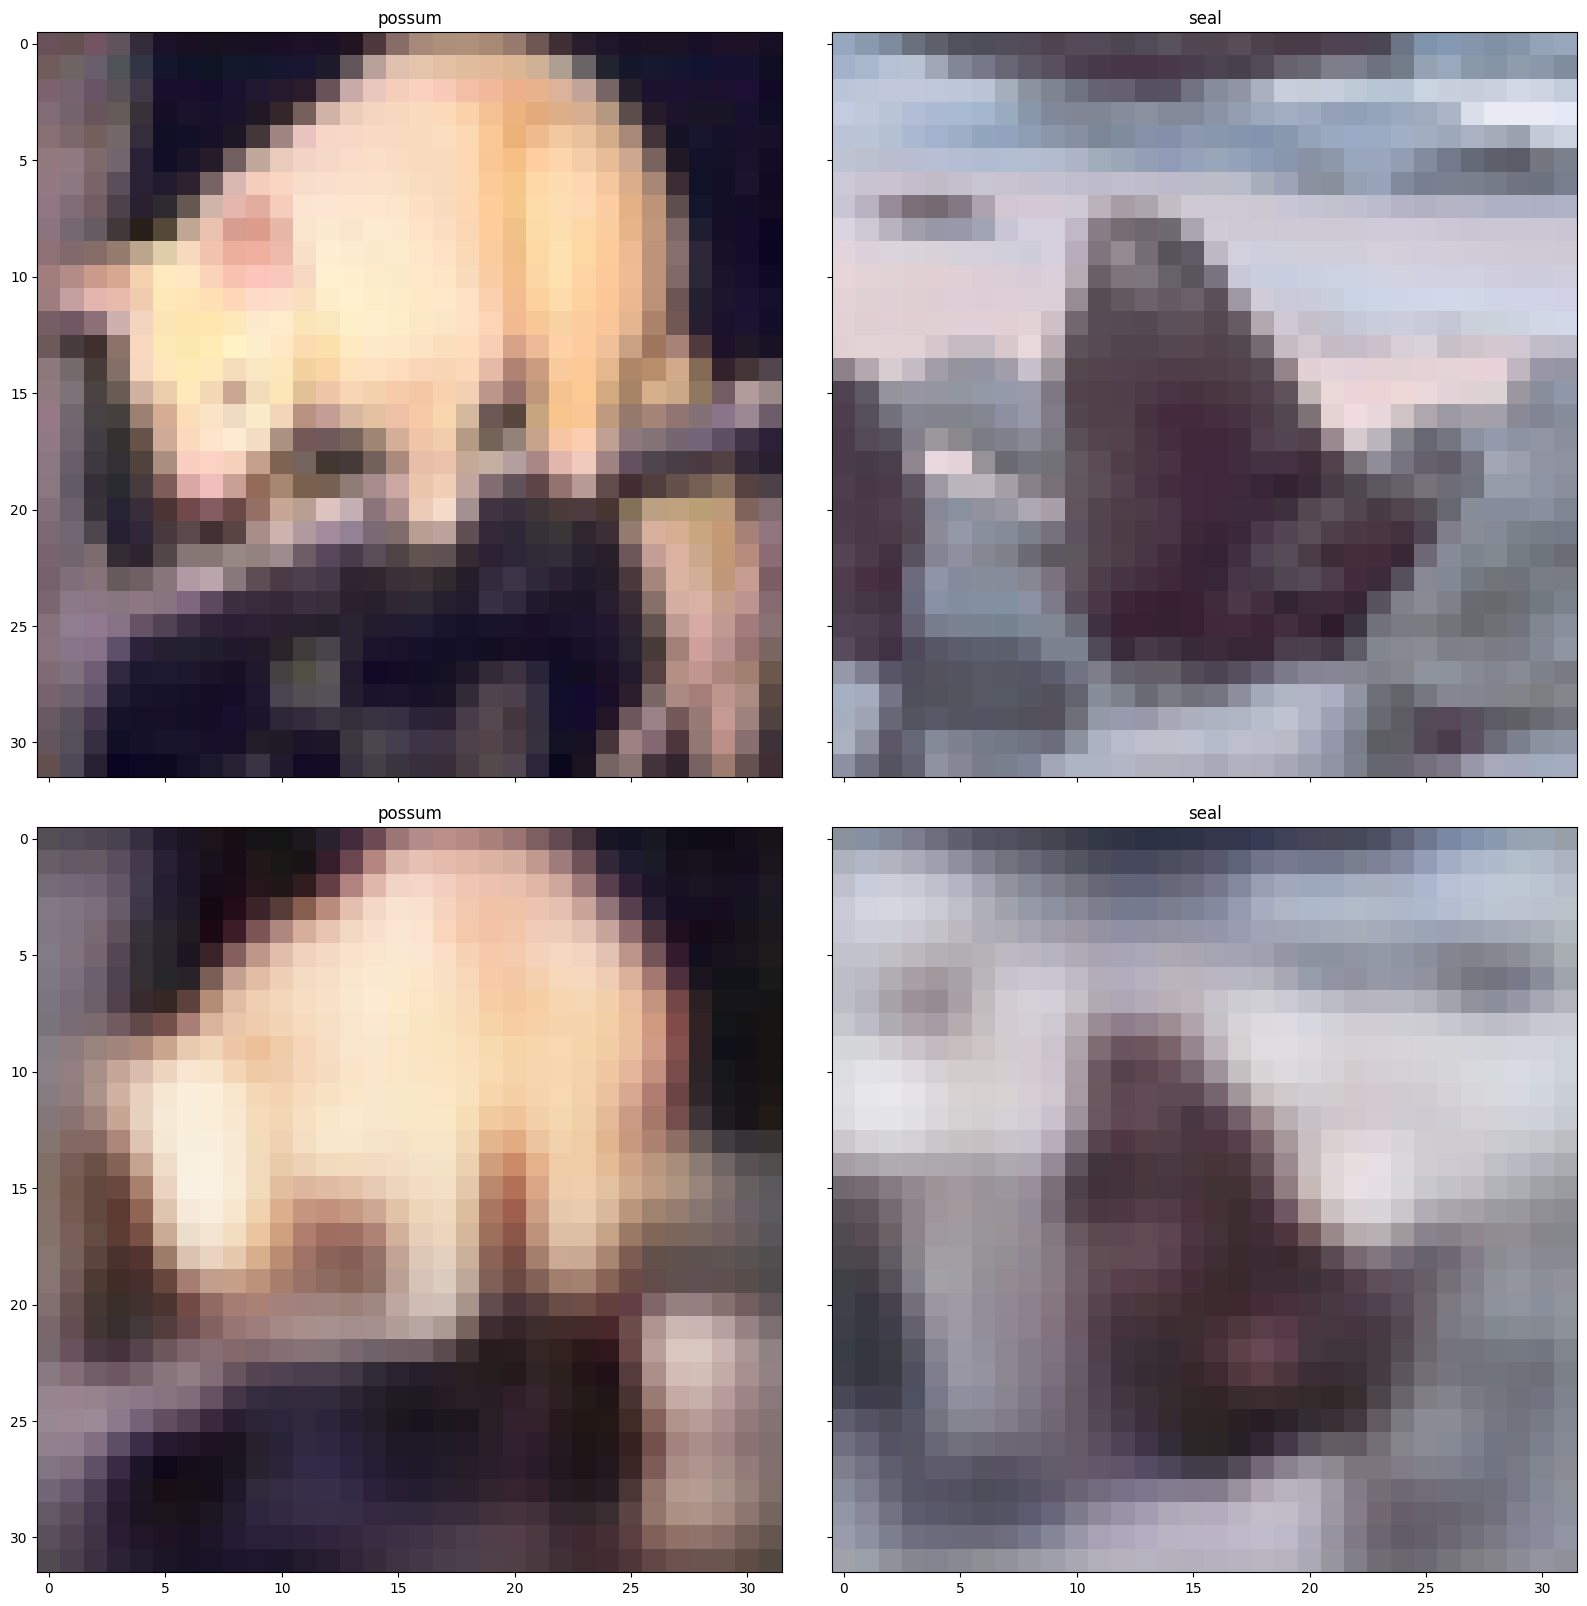

In [6]:
fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes
                 )
labels = cifar100_label(train_targets[:2])
for i, ax in enumerate(grid):
    if i==0 or i==1 :
        ax.imshow(np.transpose(train_images[i].numpy(), (1, 2, 0)))
        ax.set_title('{0}'.format(labels[i]))
    if i==2 or i==3:
        ax.imshow(np.transpose(decoded_images[i-2].detach().numpy(), (1, 2, 0)))
        ax.set_title('{0}'.format(labels[i-2]))

plt.show()

We see that the decoded images have a strong resemblance to the original images, but note that these images are from the training set, meaning our model was optimized to work on these images. Let's now take a look at what our reconstructed images look like when we use images from the testing set:

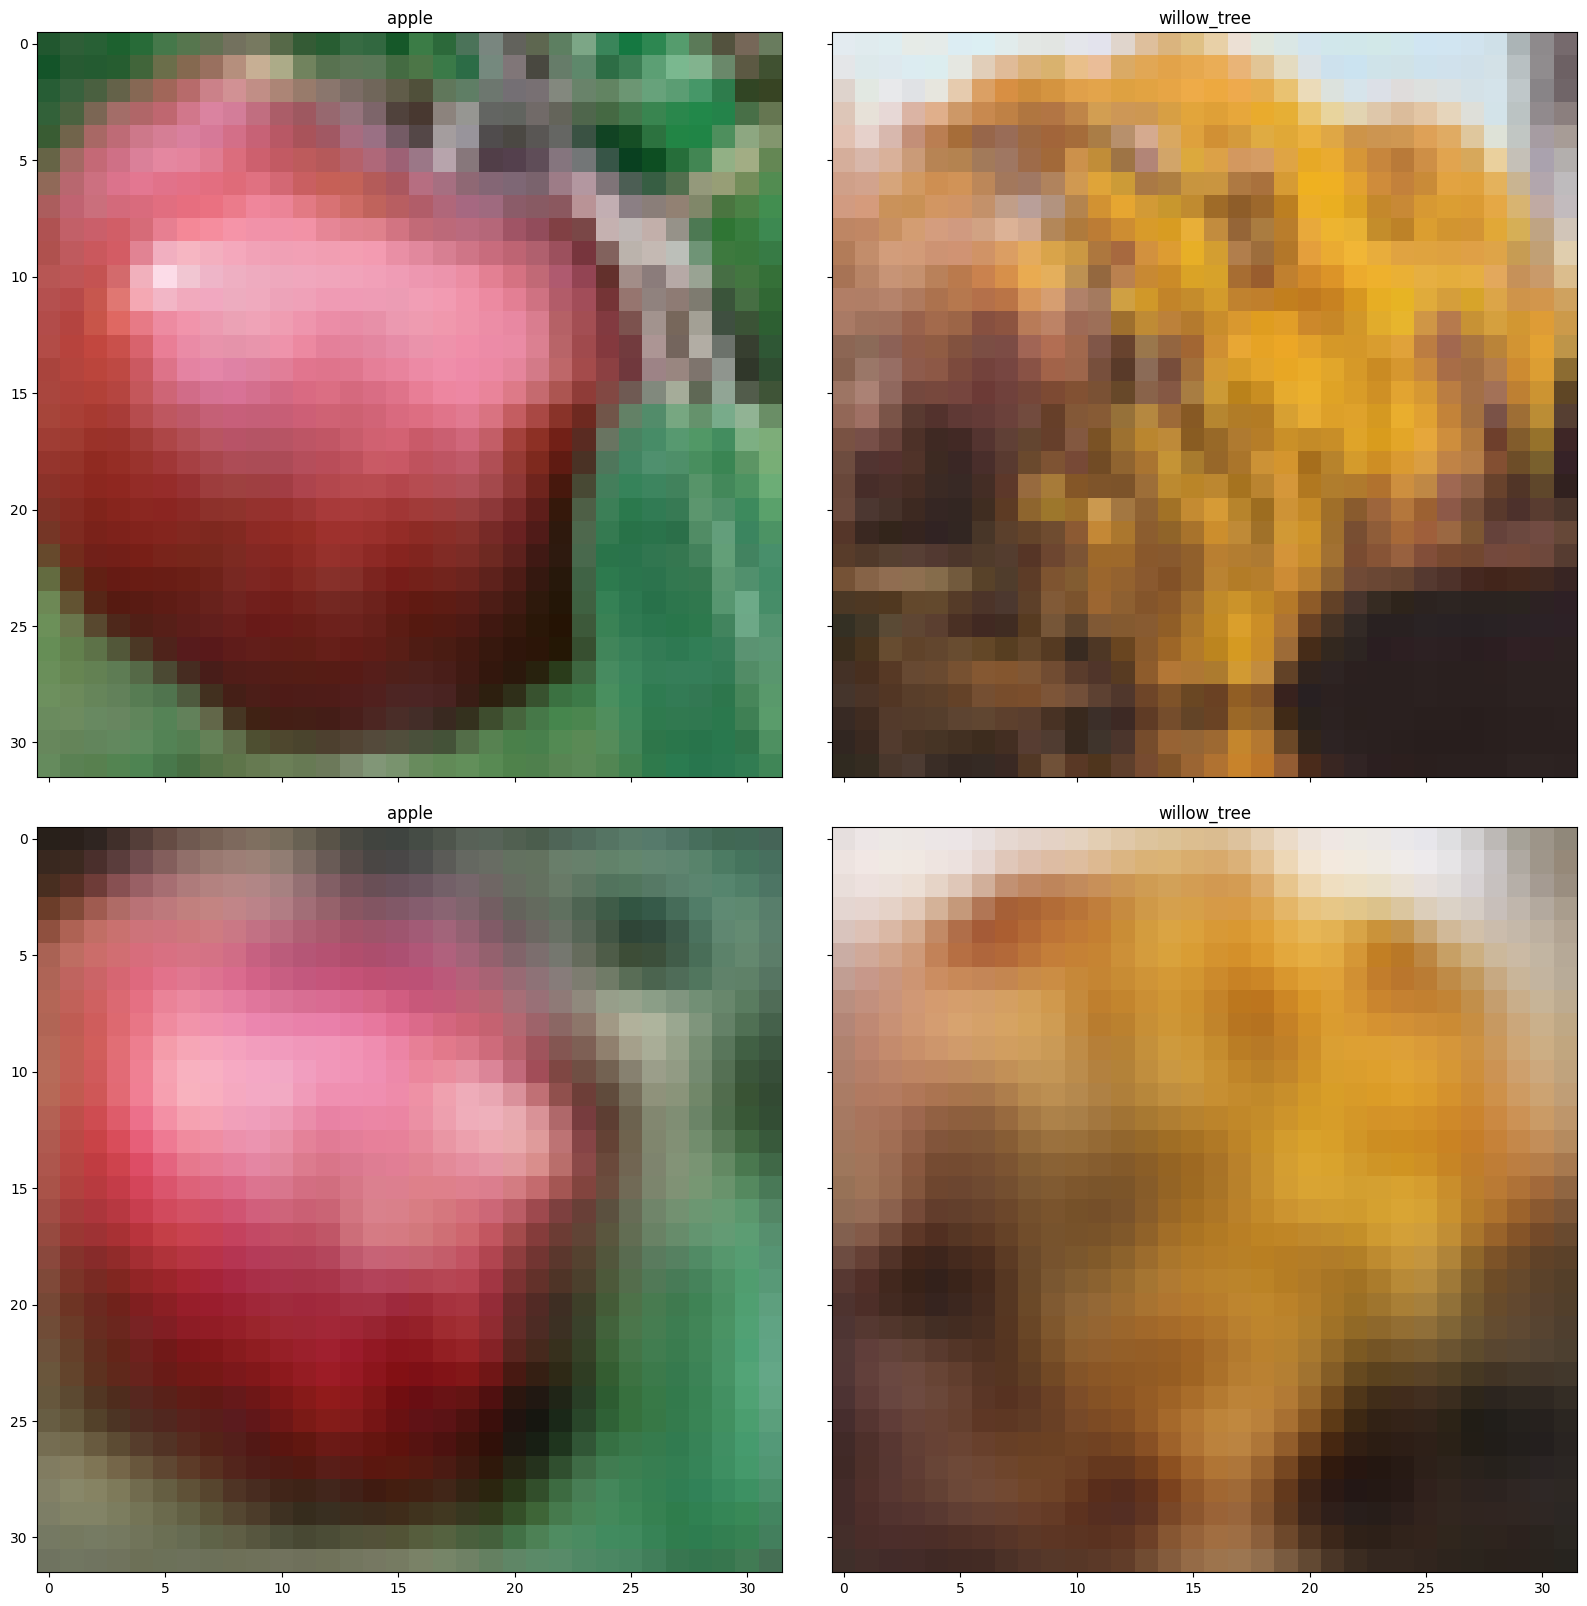

In [7]:
# Let's encode two of the images (from the test set)
encoded_images = model.encoder(test_images[:2])

# Let's now decode two of the images
decoded_images = model.decoder(encoded_images)

# Let's now print the image grid
fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes
                 )
labels = cifar100_label(test_targets[:2])
for i, ax in enumerate(grid):
    if i==0 or i==1 :
        ax.imshow(np.transpose(test_images[i].numpy(), (1, 2, 0)))
        ax.set_title('{0}'.format(labels[i]))
    if i==2 or i==3:
        ax.imshow(np.transpose(decoded_images[i-2].detach().numpy(), (1, 2, 0)))
        ax.set_title('{0}'.format(labels[i-2]))

plt.show()

Again it appears qualitatively that our autoencoder is successfully reconstructing these images very well! and this time on data from the test set, that it hasn't seen before, so it appears the autoencoder is successfully encoding the images into a small latent representation and then is successfully able to reconstruct the original image from this latent representation (not pixel for pixel, but close in appearance!). So far we have explored the performance of the autoencoder with a latent dimension of 128, but how would the autoencoder perform if we change the size of the latent dimension? This is what we will investigate now. On BluePebble I have trained a variety of autoencoders with differing latent dimensions, let's now observe how they did during training:

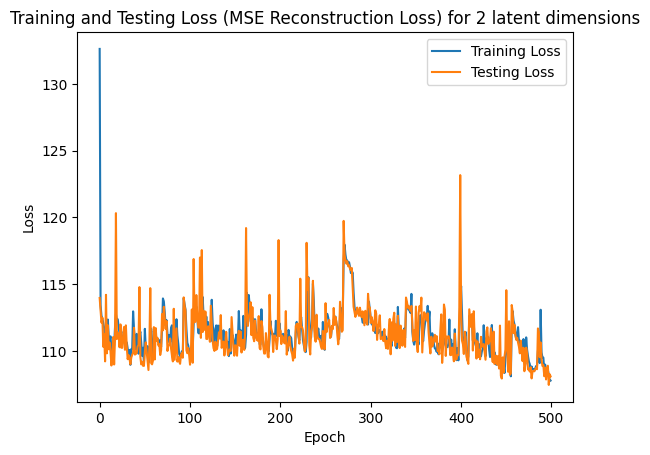

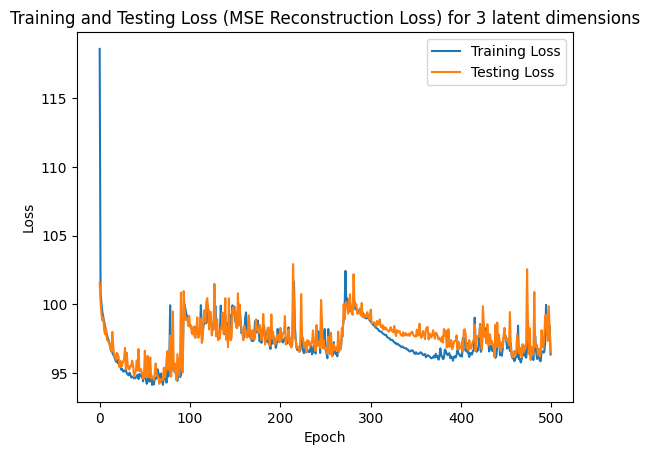

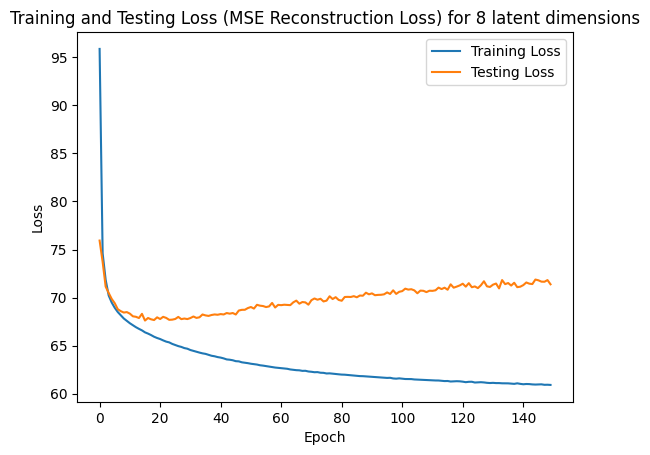

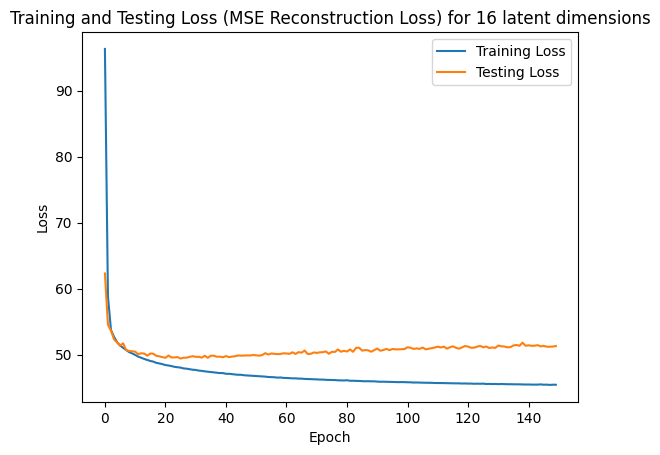

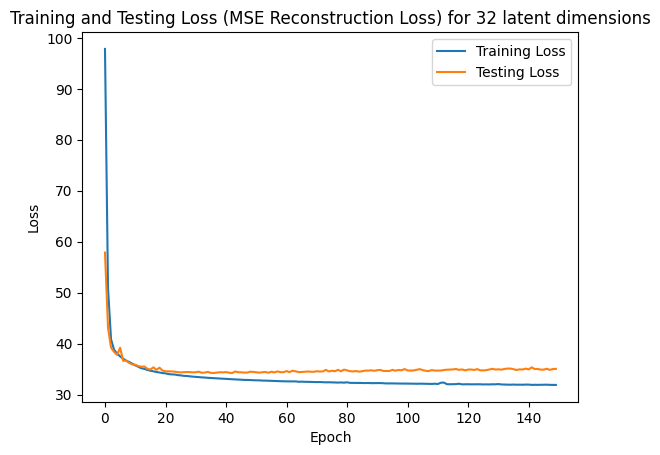

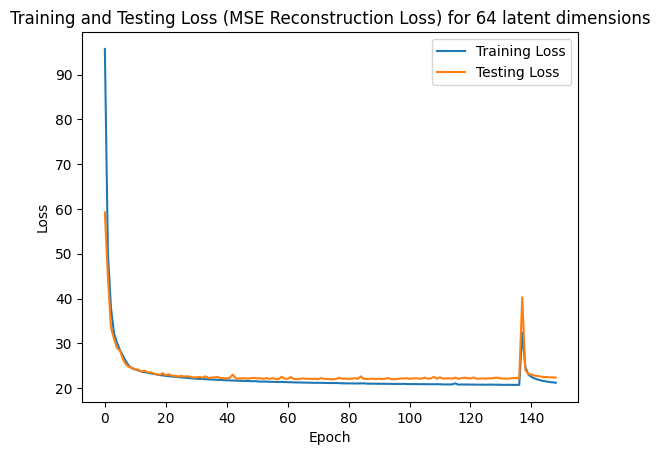

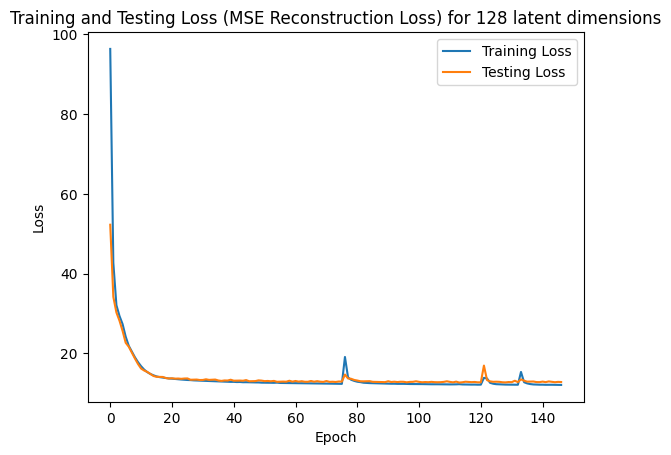

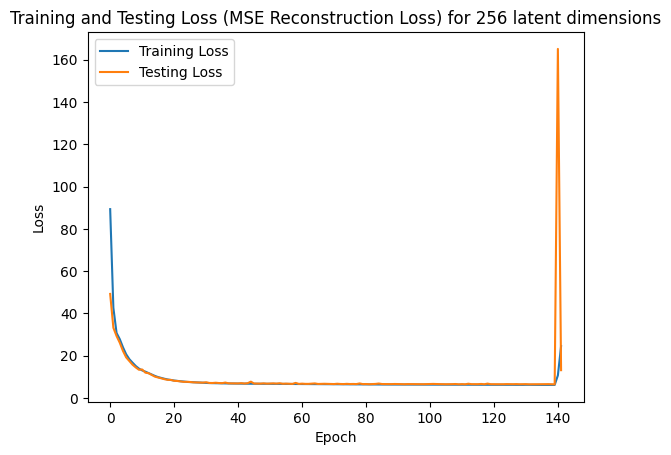

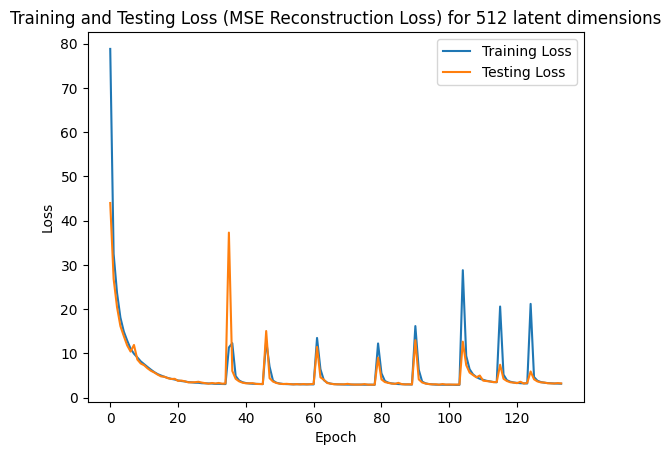

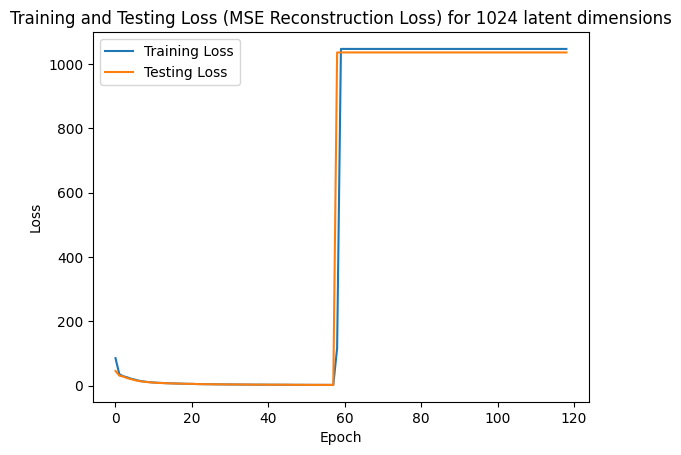

In [10]:
lat_dims = [2, 3, 8, 16, 32, 64, 128, 256, 512, 1024]
for i in lat_dims:
    plot_loss(i)

The first thing we notice is that for small latent dimensions (namely 2 and 3), the training loss is extremely noisy, ie. it has high variability especially in contrast to our other plots, we also notice that the training loss goes through periods of increase before decreasing again and that the number of epochs we have to train for is much larger (it hits the max of 500 epochs). It is worth noting that we train the autoencoders until either the loss is no longer improving or we've reached 500 epochs of training. For latent dimensions 8, 16 and 32 we see less noise in the loss and it takes many fewer epochs for training to finish, we do see the testing loss starting to slowly rise in all of these plots though showing the beginnings of our autoencoders over fitting. For latent dimensions 64, 128, 256 and 512 we see again the testing and training loss initially decreasing, but this time without the testing loss starting to increase later on, we do however now see spikes where the training and testing loss increase. Overall these plots are what we might expect from a model that is succeeding in learning something from the data, except for with latent dimensions 2 and 3 where the loss is extremely variable and it struggles to reduce the loss to small values. This indicates that perhaps for very small latent dimensions the autoencoders struggle to reduce reconstruction loss on the data as the latent dimension is too small to encode enough information about the input image.

Now let's plot the reconstruction of one of the images (from the test set) done by each model so that we can qualitatively compare the differences between the models: 

Lightning automatically upgraded your loaded checkpoint from v1.9.4 to v2.0.1.post0. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint --file saved_models/autoencoder_2.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.9.4 to v2.0.1.post0. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint --file saved_models/autoencoder_3.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.9.4 to v2.0.1.post0. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint --file saved_models/autoencoder_8.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.9.4 to v2.0.1.post0. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint --file saved_models/autoencoder_16.ckpt`
Lightning automatically upgraded your loaded checkpoint fro

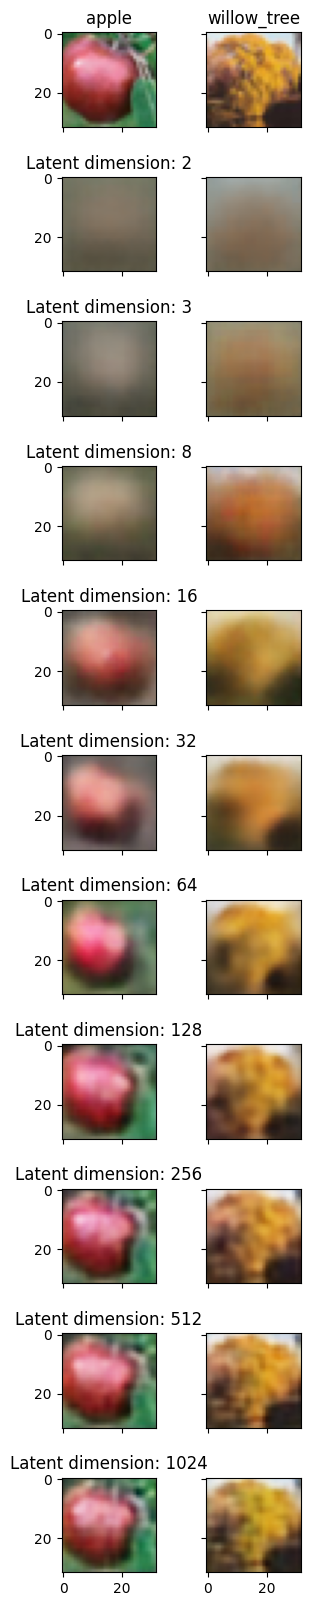

In [12]:
encoded_images = []
decoded_images = []
for i in lat_dims:
    # Load in our model that we trained on BluePebble
    model = VAE.AutoEncoder.load_from_checkpoint("saved_models/autoencoder_"+str(i)+".ckpt")

    # disable randomness, dropout, etc...
    model.eval()
    # Let's encode two of the images (from the test set)
    enc = model.encoder(test_images[:2])
    encoded_images.append(enc)

    # Let's now decode two of the images
    decoded_images.append(model.decoder(enc))

# Let's now print the image grid
fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(11, 2), 
                 axes_pad=0.5, 
                 )
labels = cifar100_label(test_targets[:2])
c=0
for i, ax in enumerate(grid):
    if i < 2:
        ax.imshow(np.transpose(test_images[i].numpy(), (1, 2, 0)))
        ax.set_title('{0}'.format(labels[i]))
    else:
        if i%2 == 0 and i != 2:
            c +=1 
        ax.imshow(np.transpose(decoded_images[c][i%2].detach().numpy(), (1, 2, 0)))
        if i%2 == 0:
            ax.set_title('Latent dimension: {0}'.format(lat_dims[c]))

plt.show()

Looking at the reconstructed images above we see a very definite story, as the number of latent dimensions increases so does the resemblance between it and the input image, ie. as the amount of information that the autoencoder is able to encode with increases, it's ability to reconstruct the original image increases, which makes sense as it can encode more information about the original image in its latent representation in the middle of the autoencoder. Another thing we note from the above plot is the reconstructed images with latent dimension 512 are nothing alike the original input image, which means there is a cap to how much we can increase the latent dimension to where it will still work. This cap will be determined by the architecture of your network and the size of the images you are working on, if we increase the size of the latent dimension to even higher values the network then begins to really struggle to reduce the training loss. 

Let's now examine what the latent space of the auto encoders look like
<!-- TODO: add text to above-->

In [ ]:
# Add code for plotting latent spaces

<!-- TODO: comment on above plots -->

# The Variational Auto Encoder
The Variational Auto Encoder (VAE) sets out to solve the problems found in the autoencoder, mainly the lacking of a robust and informative latent space. Largely the VAE is the same as the AE, except with the VAE we aim to model the latent space as a probability distribution, specifically the Gaussian distribution, this has the added benefit of allowing us to sample from the latent space and generate new data (ie. it is a generative model). This is employed in the VAE by adding two heads at the bottleneck layer (the last layer of the encoder) one which models the mean of the distribution and the other the covariance. The other change is we add the KL divergence between the latent space and a standard Gaussian distribution. We trained the VAE on CIFAR100 for multiple different sizes for the latent dimension, let's now look at how it performed for a latent dimension size of 256. First let's look at how the training and testing loss evolved over training for each epoch:

In [ ]:
# # Create plot of the training and testing loss from csv file
# import pandas as pd
# import matplotlib.pyplot as plt

# # Create plot of the training and testing accuracy from csv file
# def plot_loss(l_dim):
#     # Read the csv file
#     df_train = pd.read_csv("results/vae_" + str(l_dim) +"_train.csv")
#     df_test = pd.read_csv("results/vae_" + str(l_dim) + "_test.csv")

#     # Create the plot
#     plt.plot(df_train["Value"], label="Training Loss")
#     plt.plot(df_test["Value"], label="Testing Loss")
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.title("Training and Testing Loss (MSE Reconstruction Loss) for " + str(l_dim) + " latent dimensions")
#     plt.legend()
#     plt.show()

# # Use the function we just created to plot the loss
# plot_loss(256)

Let's now look at how it performs on reconstructing some images from the testing set:

Files already downloaded and verified
Files already downloaded and verified


Lightning automatically upgraded your loaded checkpoint from v1.9.4 to v2.0.1.post0. To apply the upgrade to your files permanently, run `python -m lightning.pytorch.utilities.upgrade_checkpoint --file saved_models_CIFAR10/varautoencoder_512.ckpt`


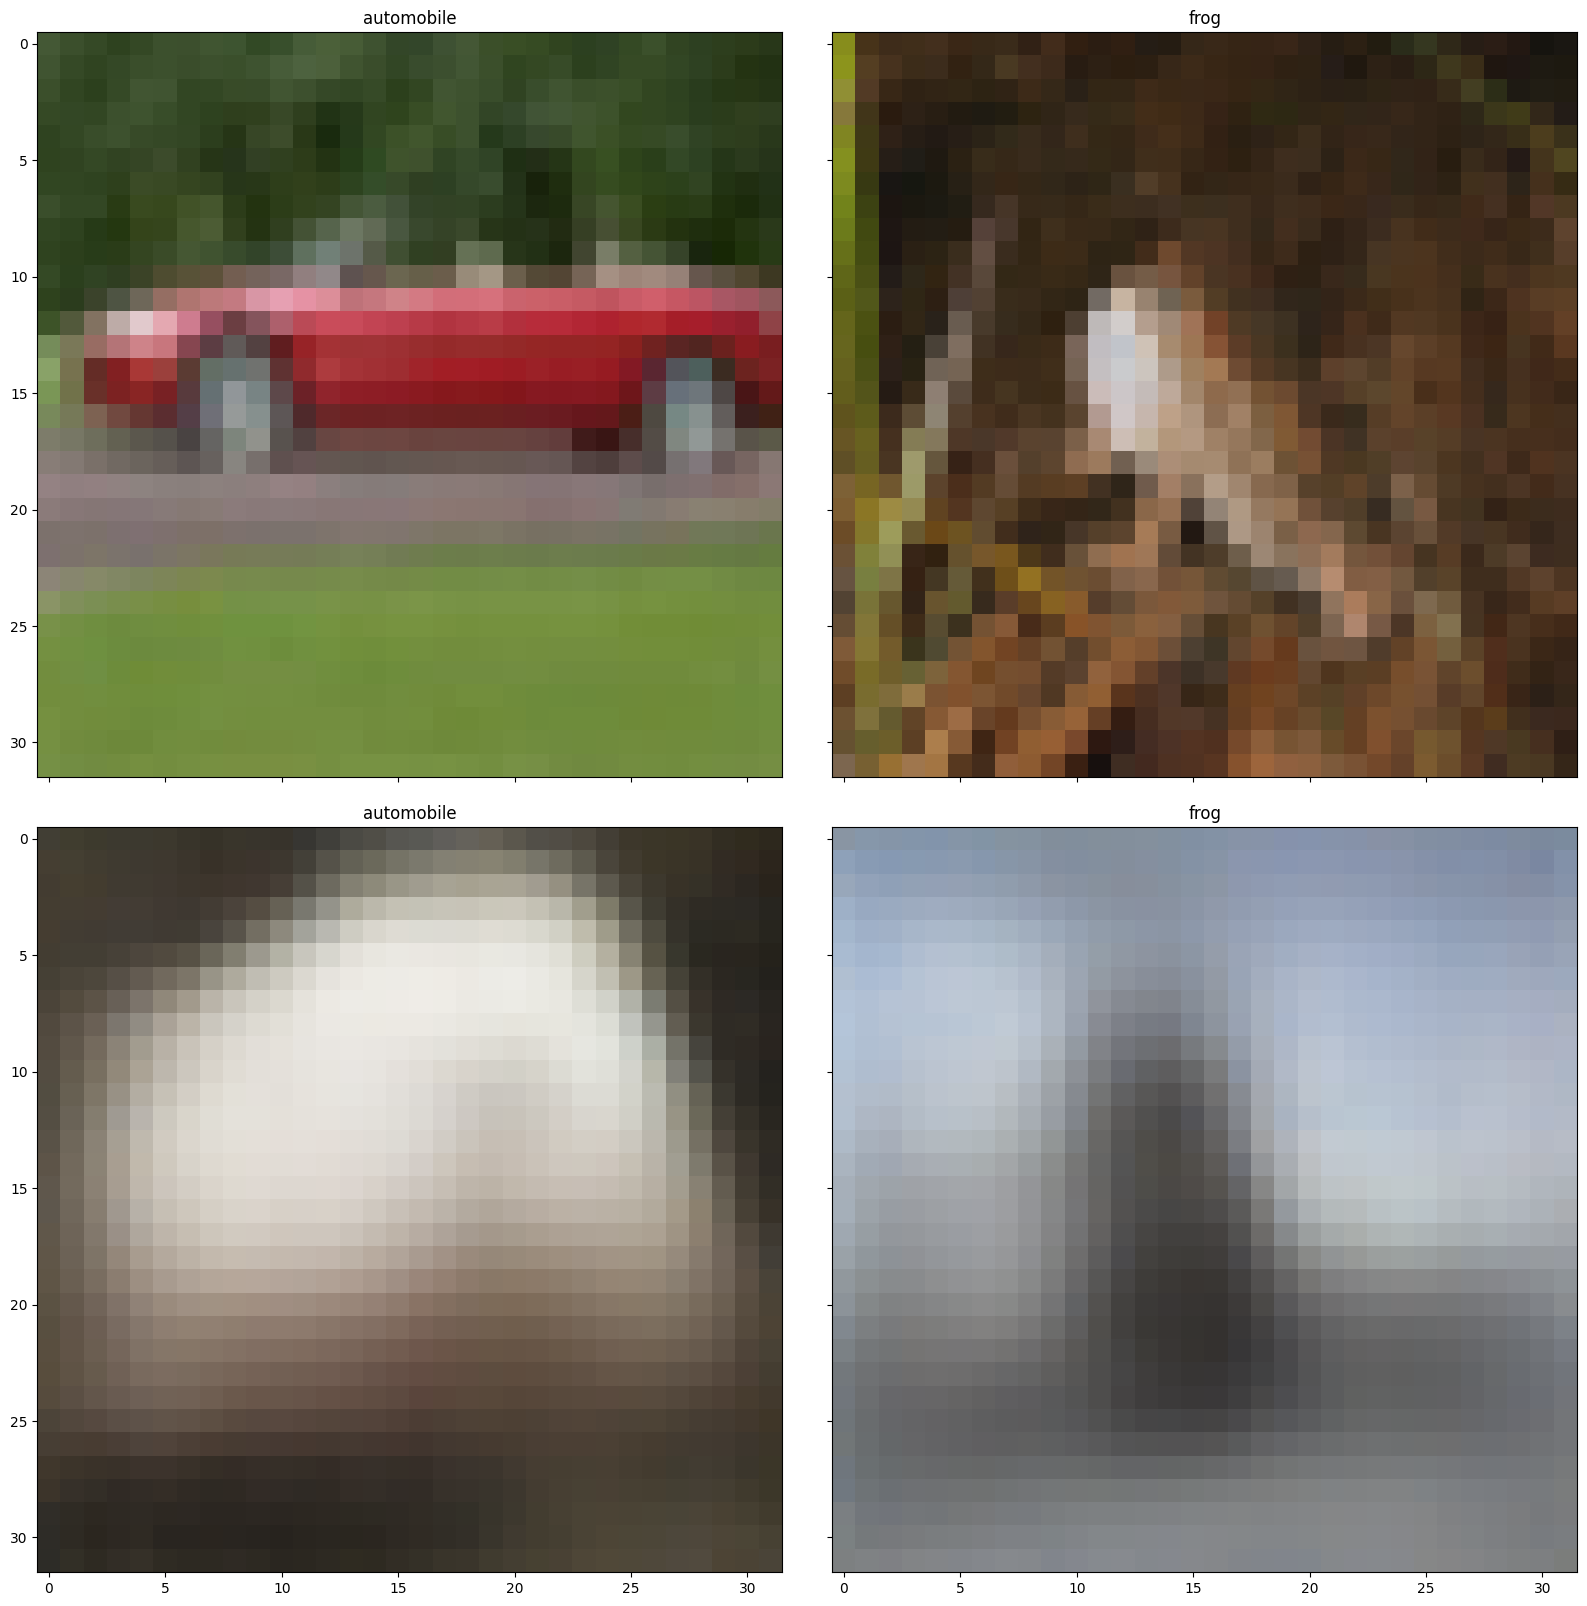

In [17]:
# Create the training and testing dataloaders and extract some images and their labels from the training set and test set
training_loader_10, test_loader_10 = data.get_data_loader("CIFAR10", 64, device)
train_images_10, train_targets_10 = next(iter(training_loader_10))
test_images_10, test_targets_10 = next(iter(test_loader_10))
labels_10 = cifar10_label(train_targets_10[:2])
# TODO: remove above

import VAE
# Load in our model that we trained on BluePebble
model = VAE.VarAutoEncoder.load_from_checkpoint("saved_models_CIFAR10/varautoencoder_512.ckpt")

# disable randomness, dropout, etc...
model.eval()

# Let's now decode two of the images
decoded_images = model.forward(train_images[:2])

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes
                 )
labels = cifar10_label(train_targets_10[:2])
for i, ax in enumerate(grid):
    if i==0 or i==1 :
        ax.imshow(np.transpose(train_images_10[i].numpy(), (1, 2, 0)))
        ax.set_title('{0}'.format(labels_10[i]))
    if i==2 or i==3:
        ax.imshow(np.transpose(decoded_images[i-2].detach().numpy(), (1, 2, 0)))
        ax.set_title('{0}'.format(labels_10[i-2]))

plt.show()